In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
# Parameters
kB = 1.380649e-23

In [3]:
def calculate_probability(E_i, T):
    Z = np.sum(np.exp(-np.array(energies) / (kB * T)))
    p = (1/Z) * np.exp(-E_i / (kB * T))   # Eq 2.1
    return p

In [4]:
def next_state(current_state, energies, T):
    # Roulette wheel selection
    
    # Get the probabilities
    probs = [calculate_probability(energy, T) for energy in energies]
    
    # Generate a random number for RWS [0,1]
    rand = np.random.random()
    
    if current_state == 0:  # If in left
        if rand < probs[0]:  # Stay in left
            return 0
        elif rand < (probs[0] + probs[1]):  # Move to middle
            return 1
        else:  # Attempt to move to right but not allowed, so stay in left
            return 0

    elif current_state == 1:  # If in middle
        if rand < probs[0]:  # Move to left
            return 0
        elif rand < (probs[0] + probs[1]):  # Stay in middle
            return 1
        else:  # Move to right
            return 2

    else:  # If in right
        if rand < probs[2]:  # Stay in right
            return 2
        elif rand < (probs[1] + probs[2]):  # Move to middle
            return 1
        else:  # Attempt to move to left but not allowed, so stay in right
            return 2

In [5]:
def get_trajectory(initial_state, steps, energies, T):
    current_state = initial_state
    trajectory = [current_state]
    
    for _ in range(steps):
        current_state = next_state(current_state, energies, T)
        trajectory.append(current_state)
    
    return trajectory

## 2.1 a) Equilibrium probability distributions

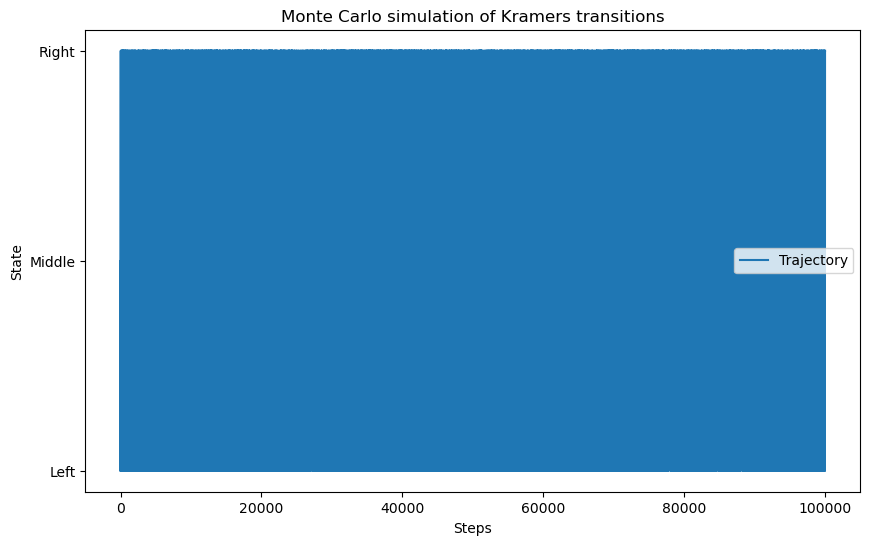

In [6]:
# Parameters
T = 300
Eb = 2*kB*T
# Energies for states
energies = [0, Eb, 0]   # [left, middle, right]
initial_state = 0  # Starting at left
steps = 10**5

trajectory = get_trajectory(initial_state, steps, energies, T)

# Plotting trajectory
plt.figure(figsize=(10,6))
plt.plot(trajectory, label="Trajectory")
plt.xlabel("Steps")
plt.ylabel("State")
plt.title("Monte Carlo simulation of Kramers transitions")
plt.yticks([0, 1, 2], ["Left", "Middle", "Right"])
plt.legend()
plt.show()

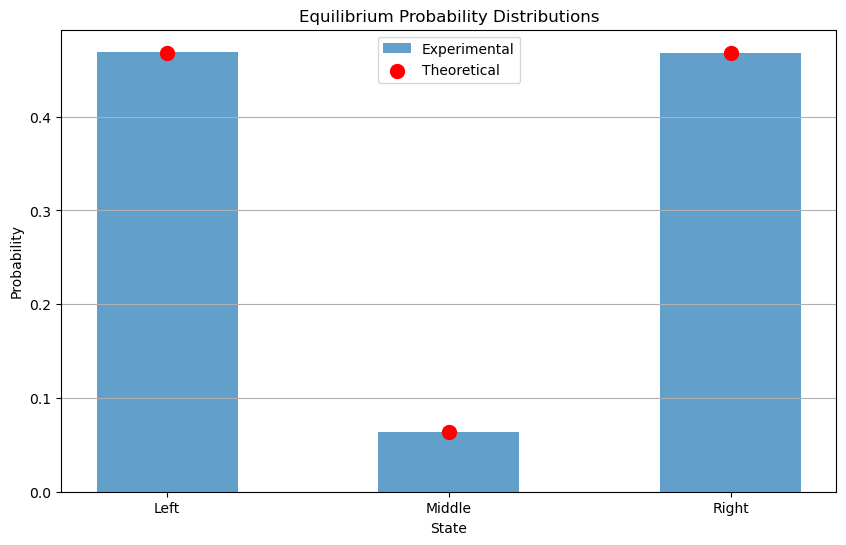

In [7]:
# Get theoretical probabilities
probs = [calculate_probability(energy, T) for energy in energies]

# Histogram of states for equilibrium probability distributions
plt.figure(figsize=(10,6))
plt.hist(trajectory, bins=[-0.5, 0.5, 1.5, 2.5], rwidth=0.5, density=True, alpha=0.7, label="Experimental")
plt.xlabel("State")
plt.ylabel("Probability")
plt.title("Equilibrium Probability Distributions")
plt.xticks([0, 1, 2], ["Left", "Middle", "Right"])
plt.grid(axis='y')

# Theoretical probabilities as red dots
states = [0, 1, 2]
plt.scatter(states, probs, color='red', s=100, zorder=5, label="Theoretical")
plt.legend()
plt.show()

## 2.1 b) Effect of Eb and T on transition frequency

In [8]:
def compute_transition_frequency(trajectory):
    transitions = 0
    
    for i in range(1, len(trajectory)):
        if trajectory[i] != trajectory[i-1]:
            transitions += 1
            
    return transitions / len(trajectory)

In [9]:
# Varying E_b and T
Eb_values = [0.5*kB*T, kB*T, 2*kB*T, 5*kB*T]
T_values = [50, 300, 1000, 5000]
initial_state = 0   # Left

results = {}

for Eb in Eb_values:
    for T in T_values:
        energies = [0, Eb, 0]
        trajectory = get_trajectory(initial_state, steps, energies, T)
        transition_freq = compute_transition_frequency(trajectory)
        
        results[(Eb, T)] = {
            'trajectory': trajectory,
            'transition_frequency': transition_freq
        }

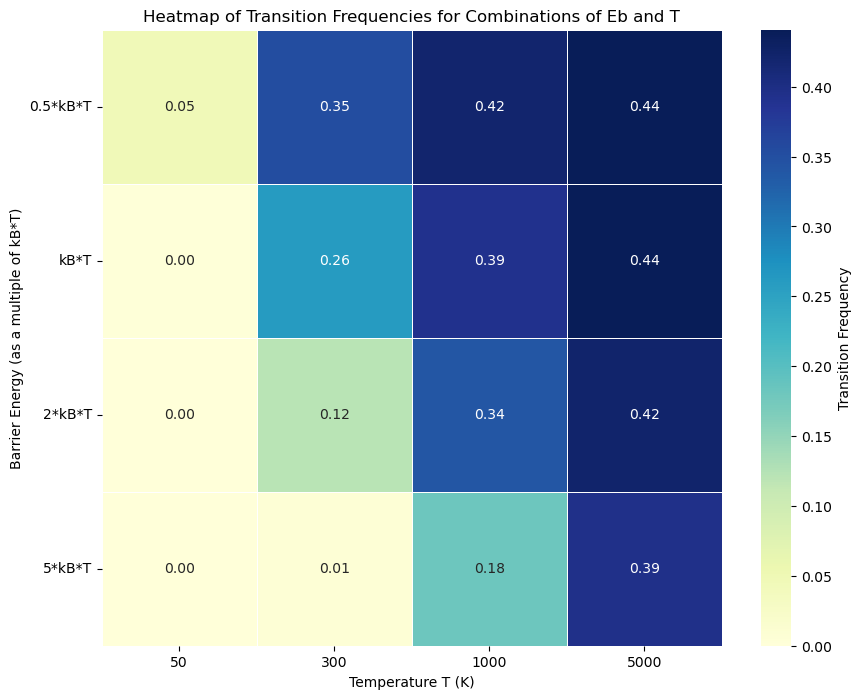

In [10]:
# Matrix for the heatmap
freq_matrix = np.zeros((len(Eb_values), len(T_values)))

# Fill matrix with transition frequencies
for i, Eb in enumerate(Eb_values):
    for j, T in enumerate(T_values):
        freq_matrix[i, j] = results[(Eb, T)]['transition_frequency']

# Labels for y axis (Eb)
eb_labels = ['0.5*kB*T', 'kB*T', '2*kB*T', '5*kB*T']
df = pd.DataFrame(freq_matrix, index=eb_labels, columns=T_values)

# Heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(df, annot=True, fmt=".2f", linewidths=0.5, cmap="YlGnBu", cbar_kws={'label': 'Transition Frequency'})
plt.title("Heatmap of Transition Frequencies for Combinations of Eb and T")
plt.xlabel("Temperature T (K)")
plt.ylabel("Barrier Energy (as a multiple of kB*T)")
plt.yticks(rotation=0)
plt.show()

## 2.1 c) Effect of Eb and T on escape time

In [11]:
def get_escape_time(energies, T):
    current_state = 0
    steps = 0
    
    while current_state != 2:
        current_state = next_state(current_state, energies, T)
        steps += 1
        
    return steps

In [13]:
# Some varying Eb and T
Eb_values = [0.5*kB*T, kB*T, 2*kB*T, 3*kB*T]
T_values = [50, 300, 1000, 5000]
escape_time_results = {}

for Eb in Eb_values:
    for T in T_values:
        energies = [0, Eb, 0]
        
        escape_times = [get_escape_time(energies, T) for _ in range(1000)]
        average_escape_time = np.mean(escape_times)
        
        escape_time_results[(Eb, T)] = {
            'escape_times': escape_times,
            'average_escape_time': average_escape_time
        }

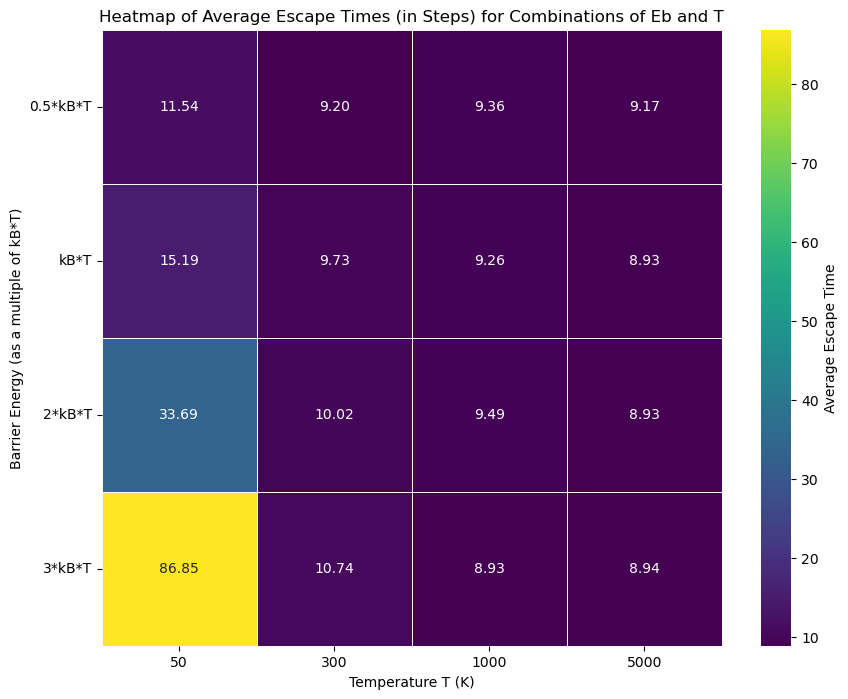

In [14]:
# Matrix for the heatmap
escape_time_matrix = np.zeros((len(Eb_values), len(T_values)))

# Fill matrix with average escape times
for i, Eb in enumerate(Eb_values):
    for j, T in enumerate(T_values):
        escape_time_matrix[i, j] = escape_time_results[(Eb, T)]['average_escape_time']

# Labels for y axis (Eb)
eb_labels = ['0.5*kB*T', 'kB*T', '2*kB*T', '3*kB*T']
df_escape_times = pd.DataFrame(escape_time_matrix, index=eb_labels, columns=T_values)

# Heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(df_escape_times, annot=True, fmt=".2f", linewidths=0.5, cmap="viridis", cbar_kws={'label': 'Average Escape Time'})
plt.title("Heatmap of Average Escape Times (in Steps) for Combinations of Eb and T")
plt.xlabel("Temperature T (K)")
plt.ylabel("Barrier Energy (as a multiple of kB*T)")
plt.yticks(rotation=0)
plt.show()

**Conclusion 1:** When having same energy barrier, the average escape time is higher when having low temperature. intuitively reasonable, in low temperature, the particle moves less.

**Conclusion 2:** When having same temperature, the average escape time increases when having higher energy barrier. Intuitively reasonable, higher energy barrier makes it harder (smaller probability) for the particle to move to the middle state, therefore harder to reach to the right.